In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from tqdm import tqdm
import vrplib


In [7]:
class Customer():
    def __init__(self, x1, x2, demand):
        self.coords = np.array([x1, x2])
        self.demand = demand

class Vehicle():
    def __init__(self, capacity):
        self.remaining_capacity = capacity
        self.route = [0]

    def route_length(self, distance_matrix):
        length = 0
        for i in range(len(self.route) - 1):
            length += distance_matrix[self.route[i]][self.route[i+1]]

        return length

class VRP():
    @staticmethod
    def plot_routes(vehicles, customers):
        customer_coords = np.array([customers[i].coords for i in range(len(customers))])

        for v in vehicles:
            plt.plot(customer_coords[v.route][:,0], customer_coords[v.route][:,1])
            
        for i, customer in enumerate(customers):
            plt.annotate(i, customer.coords)

    @staticmethod
    def compute_distances(customers):
        distances = np.ones([len(customers), len(customers)])
    
        for i in range(len(customers)):
            for j in range(len(customers)):
                distances[i][j] = np.linalg.norm(customers[i].coords - customers[j].coords)
    
        return distances

    @staticmethod
    def greed_search(customers, distance_matrix, veh_capacity=100):
        unvisited = np.ones((len(customers)), dtype=bool)
        unvisited[0] = False
        
        vehicles = [Vehicle(veh_capacity)]
        veh_id = 0
    
        dists = distance_matrix[vehicles[veh_id].route[-1]][unvisited]
    
        while(sum(unvisited) != 0):
            
            nearest_customers = np.argsort(distance_matrix[vehicles[veh_id].route[-1]]) # айдишники клиентов в порядке убывания расстояния 
            for customer_id in nearest_customers[unvisited[nearest_customers]]:
                if customers[customer_id].demand <= vehicles[veh_id].remaining_capacity:
                    vehicles[veh_id].remaining_capacity -= customers[customer_id].demand
                    vehicles[veh_id].route.append(customer_id)
                    unvisited[customer_id] = False
                    break;
    
            # если в машину не влез ни один из непосещенных клиентов
            if(unvisited[customer_id]):
                vehicles[veh_id].route.append(0)
                vehicles.append(Vehicle(veh_capacity))
                veh_id += 1
                
        vehicles[veh_id].route.append(0)
                
        return vehicles
        
    @staticmethod
    def tabu_search(vehicles, customers, distance_matrix, tabu_len, non_improvement_len):
        # Лучшее решение задачи среди всех итераций поиска
        best_solution_veh = copy.deepcopy(vehicles)
        best_solution_cost = VRP.total_route_length(best_solution_veh, distance_matrix)

        # Переменная для хранения изменений общей длины маршрутов
        current_cost = best_solution_cost
        
        tabu_matrix = np.zeros((len(customers), len(customers)))
        non_improvement_steps = 0
        a = 0 # Если критерий остановки не срабатывает то выходим по числу шагов
        while(a < 100000):
        #while(True):
            a += 1
            # Лучшее решение на данной итерации поиска. TODO: подумать над неймингом переменных
            best_cost_delta = float("inf")
            best_veh_1 = -1
            best_veh_2 = -1
            best_i = -1
            best_j = -1
            
            for veh_1_id, veh_1 in enumerate(vehicles):
                for i in range(1, len(veh_1.route) - 1):
                    for veh_2 in vehicles:
                        for j in range(len(veh_2.route) - 1):
                            if(tabu_matrix[i][j] > 0):
                                break
                            # Проверка, что клиент влезет в маршрут у veh_2
                            if(customers[veh_1.route[i]].demand > veh_2.remaining_capacity):
                                break
                            # Случай, когда мы пытаемся в одном и том же маршруте переставить клиента с id i на позицию j + 1, при i = j + 1 
                            # не имеет смысла, и, более того, ломает формулу для расчета cost_delta, поэтому пропускаем такой случай
                            if((veh_1 == veh_2) and (j == i or i == j + 1)):
                                break
    
                            cost_delta = - distance_matrix[veh_1.route[i - 1], veh_1.route[i]] \
                                         - distance_matrix[veh_1.route[i], veh_1.route[i + 1]] \
                                         + distance_matrix[veh_1.route[i - 1], veh_1.route[i + 1]] \
                                         - distance_matrix[veh_2.route[j], veh_2.route[j + 1]] \
                                         + distance_matrix[veh_2.route[j], veh_1.route[i]] \
                                         + distance_matrix[veh_1.route[i], veh_2.route[j + 1]]
                            
                            if(cost_delta < best_cost_delta):
                                best_cost_delta = cost_delta
                                best_veh_1 = veh_1
                                best_veh_2 = veh_2
                                best_i = i
                                best_j = j

            tabu_matrix[tabu_matrix != 0] -= 1
            
            if(best_veh_1 != -1 and best_veh_2 != -1):
                best_veh_1.remaining_capacity += customers[best_veh_1.route[best_i]].demand
                best_veh_2.remaining_capacity -= customers[best_veh_1.route[best_i]].demand
                current_cost += best_cost_delta
        
                best_veh_2.route.insert(best_j + 1, best_veh_1.route[best_i])
                if(best_veh_1 == best_veh_2):
                    if(best_j + 1 < best_i):
                        del best_veh_1.route[best_i + 1]
                else:
                    del best_veh_1.route[best_i]
                
                tabu_matrix[best_i, best_j] = tabu_len
            
            if(current_cost < best_solution_cost):
                non_improvement_steps = 0
                best_solution_cost = current_cost
                best_solution_veh = copy.deepcopy(vehicles)
            else:
                non_improvement_steps += 1

            if(non_improvement_steps == non_improvement_len):
                break
    
        return best_solution_veh

    @staticmethod
    def run(customers, vehicle_capacity, tabu_len, non_improvement_len, distance_matrix=None):
        if(distance_matrix is None):
            distance_matrix = VRP.compute_distances(customers)
        vehicles = VRP.greed_search(customers, distance_matrix, veh_capacity=vehicle_capacity)
        #VRP.plot_routes(vehicles, customers)
        veh_modified = VRP.tabu_search(vehicles, customers, distance_matrix, tabu_len, non_improvement_len)
        
        return {'vehicles_optimized': veh_modified, 'distance_matrix': distance_matrix}

    @staticmethod
    def total_route_length(vehicles, distance_matrix):
        length = 0
        for v in vehicles:
            length += v.route_length(distance_matrix)
    
        return length

    # Изначальный парсер vrp файлов, оказывается есть либа vrplib с нормальной реализацией парсера
    @staticmethod
    def read_vrp(path):
        capacity = 0
        customers = []
        
        vrp_file = ''
        with open(path, 'r') as f:
            vrp_file = f.read()

        vrp_file = vrp_file.split('\n')
            
        num_customers = int(vrp_file[3].split()[-1])
        vehicle_capacity = int(vrp_file[5].split()[-1])
        for i in range(7, 7 + num_customers):
            coords = vrp_file[i].split()
            customers.append(Customer(int(coords[1]), int(coords[2]), int(vrp_file[i + num_customers + 1].split()[1])))
        
        
        with open(path.split('.')[0] + '.sol', 'r') as f:
            sol_file = f.read()
    
        return {'capacity': vehicle_capacity, 'customers': customers, 'sol_cost': int(sol_file.split()[-1])}

    @staticmethod
    def run_from_file(path, tabu_len=9, non_improvement_len=1000):
        instance = vrplib.read_instance(path)
        solution = vrplib.read_solution(path.split('.')[0] + '.sol')

        if(instance['edge_weight_type'] == 'EUC_2D'):
            customers = []
            for coords, demand in zip(instance['node_coord'], instance['demand']):
                customers.append(Customer(coords[0], coords[1], demand))
            res = VRP.run(customers, instance['capacity'], 9, 1000)
                
        elif(instance['edge_weight_type'] == 'EXPLICIT'):
            customers = []
            for demand in instance['demand']:
                customers.append(Customer(-1, -1, demand))
                
            res = VRP.run(customers, instance['capacity'], tabu_len, non_improvement_len, distance_matrix=instance['edge_weight'])
            
        res['score'] = (VRP.total_route_length(res['vehicles_optimized'], res['distance_matrix']) - solution['cost']) / solution['cost']
        res['customers'] = customers
        res['filename'] = path

        return res


In [8]:
import time
results = []

for benchmark in os.listdir('data'):
    print(f'processing benchmark: {benchmark}')
    benchmark_results = []
    for filename in tqdm(os.listdir(os.path.join('data', benchmark))):
        current_file = os.path.join('data', benchmark, filename)
        if(current_file.split('.')[-1] == 'vrp'):
            start = time.time()
            res = VRP.run_from_file(current_file)
            res['time'] = time.time() - start
            benchmark_results.append(res)
    results.append(benchmark_results)
            

processing benchmark: A


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:22<00:00,  2.43it/s]


processing benchmark: B


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:21<00:00,  2.13it/s]


processing benchmark: E


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:43<00:00,  1.68s/it]


In [52]:
for experiment in results[0]:
    print(experiment['filename'].split('\\')[-1], experiment['score'])

A-n32-k5.vrp 0.06617562628420846
A-n33-k5.vrp 0.023358608715116354
A-n33-k6.vrp 0.03617611629759861
A-n34-k5.vrp 0.020969066732671748
A-n36-k5.vrp 0.08908609655275788
A-n37-k5.vrp 0.045495319998262014
A-n37-k6.vrp 0.11248303032282334
A-n38-k5.vrp 0.1351734404365891
A-n39-k5.vrp 0.0784047629207056
A-n39-k6.vrp 0.016275703544178594
A-n44-k6.vrp 0.12283340813824294
A-n45-k6.vrp 0.09651760548197207
A-n45-k7.vrp 0.057056268291676586
A-n46-k7.vrp 0.11145269437456098
A-n48-k7.vrp 0.08351453579787071
A-n53-k7.vrp 0.12728738785826255
A-n54-k7.vrp 0.1087979884908409
A-n55-k9.vrp 0.07202870447495133
A-n60-k9.vrp 0.053786901140619195
A-n61-k9.vrp 0.32389722126794457
A-n62-k8.vrp 0.10405564470300052
A-n63-k10.vrp 0.04516507247502405
A-n63-k9.vrp 0.12957740796505732
A-n64-k9.vrp 0.06091870114601482
A-n65-k9.vrp 0.21818309107174966
A-n69-k9.vrp 0.07243881984011223
A-n80-k10.vrp 0.09398556454885691


In [53]:
for experiment in results[1]:
    print(experiment['filename'].split('\\')[-1], experiment['score'])

B-n31-k5.vrp 0.023600099766860744
B-n34-k5.vrp 0.028899384714706516
B-n35-k5.vrp 0.03887115995384269
B-n38-k6.vrp 0.015482264048972108
B-n39-k5.vrp 0.13435460151095477
B-n41-k6.vrp 0.09756553346003134
B-n43-k6.vrp 0.02922579758120997
B-n44-k7.vrp 0.0785880683791718
B-n45-k5.vrp 0.15851141014456652
B-n45-k6.vrp 0.06511179640980654
B-n50-k7.vrp 0.06387971754467679
B-n50-k8.vrp 0.04579299357095215
B-n51-k7.vrp 0.13851218554006706
B-n52-k7.vrp 0.04622089113193268
B-n56-k7.vrp 0.094163810712781
B-n57-k7.vrp 0.043587245202457284
B-n57-k9.vrp 0.08027073368949796
B-n63-k10.vrp 0.03714316870180958
B-n64-k9.vrp 0.17450613388002065
B-n66-k9.vrp 0.07817918877787311
B-n67-k10.vrp 0.07690789303438453
B-n68-k9.vrp 0.04064343525777079
B-n78-k10.vrp 0.07035812553732582


In [54]:
for experiment in results[2]:
    print(experiment['filename'].split('\\')[-1], experiment['score'])

E-n101-k14.vrp 0.13539136427249315
E-n101-k8.vrp 0.09126833977718364
E-n13-k4.vrp 0.17408906882591094
E-n22-k4.vrp 0.08916897017308353
E-n23-k3.vrp 0.0023943633401832093
E-n30-k3.vrp 0.06108509871073446
E-n31-k7.vrp 2.2770448548812663
E-n33-k4.vrp 0.05565793480491089
E-n51-k5.vrp 0.19666445986527747
E-n76-k10.vrp 0.19720874549433196
E-n76-k14.vrp 0.09393130146526346
E-n76-k7.vrp 0.092229308280829
E-n76-k8.vrp 0.16177697196081886


In [60]:
avg_score = 0

for experiment in results[2]:
    avg_score += experiment['score']

avg_score = avg_score / len(results[2])
print(avg_score)

0.2790700601424836


In [110]:
results_ = []
results_.extend(results[0])
results_.extend(results[1])
results_.extend(results[2])

In [160]:
results_

[{'vehicles_optimized': [<__main__.Vehicle at 0x1c831ca1660>,
  'distance_matrix': array([[  0.        ,  34.92849839,  77.87810989, ...,  62.28964601,
           16.2788206 ,  72.78049189],
         [ 34.92849839,   0.        ,  60.30754513, ...,  80.32434251,
           19.41648784,  39.05124838],
         [ 77.87810989,  60.30754513,   0.        , ...,  71.58910532,
           65.19202405,  48.        ],
         ...,
         [ 62.28964601,  80.32434251,  71.58910532, ...,   0.        ,
           65.76473219, 101.53324579],
         [ 16.2788206 ,  19.41648784,  65.19202405, ...,  65.76473219,
            0.        ,  56.5154846 ],
         [ 72.78049189,  39.05124838,  48.        , ..., 101.53324579,
           56.5154846 ,   0.        ]]),
  'score': 0.06617562628420846,
  'customers': [<__main__.Customer at 0x1c831cd4460>,
  'filename': 'data\\A\\A-n32-k5.vrp',
  'time': 0.8594357967376709},
 {'vehicles_optimized': [<__main__.Vehicle at 0x1c831c84400>,
  'distance_matrix': arra

In [165]:
y = [results_[i]['time'] for i in range(len(results_))]
x = [int(results_[i]['filename'].split('-')[-2][1:]) for i in range(len(results_))]

np.array(y)[np.argsort(x)][33]

36.584572553634644

In [162]:
np.array(y)[np.argsort(x)]

array([ 0.05726171,  0.11911798,  0.34768558,  0.3853333 ,  1.17690849,
        0.64829898,  0.8594358 ,  0.25041485,  0.53622556,  0.70546103,
        0.61725712,  0.91229296,  0.62339187,  0.43017983,  0.66807294,
        0.54479194,  0.1642251 ,  0.83162022,  0.86010075,  0.30953813,
        1.70306802,  0.27396607,  0.86775017,  0.33572626,  0.68361783,
        2.14427686,  0.47708416,  0.86490297,  0.35936379,  1.05373406,
        0.73329878,  1.01078558,  2.24276018, 36.58457255,  0.23026514,
        0.93821144,  0.88447285,  0.67472601,  0.528934  ,  1.49521661,
        0.79698038,  1.35723853,  2.6686523 ,  0.58019567,  1.68333459,
        1.50999975,  0.95850825,  0.73957372,  0.52609348,  1.68484783,
        0.47402239,  1.79714799,  2.09796357,  3.01718926,  2.34170008,
        0.60941339,  2.15265083,  1.70258594,  1.96282673,  2.49266481,
        1.53321886,  5.67331338,  2.69127417])

Text(0.5, 0, 'customers')

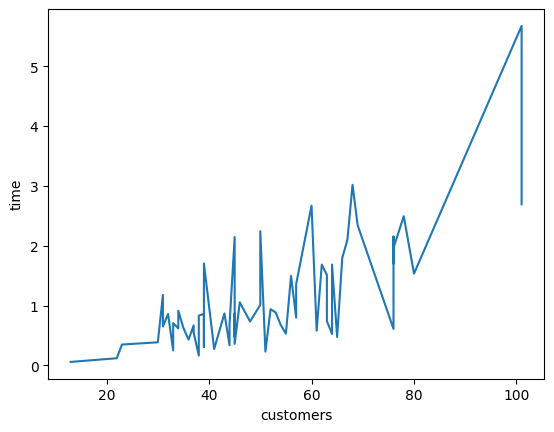

In [175]:
y = [results_[i]['time'] for i in range(len(results_))]
x = [int(results_[i]['filename'].split('-')[-2][1:]) for i in range(len(results_))]

plt.plot(np.delete(np.array(x)[np.argsort(x)], 33), np.delete(np.array(y)[np.argsort(x)], 33))
plt.ylabel('time')
plt.xlabel('customers')

Text(0.5, 0, 'customers')

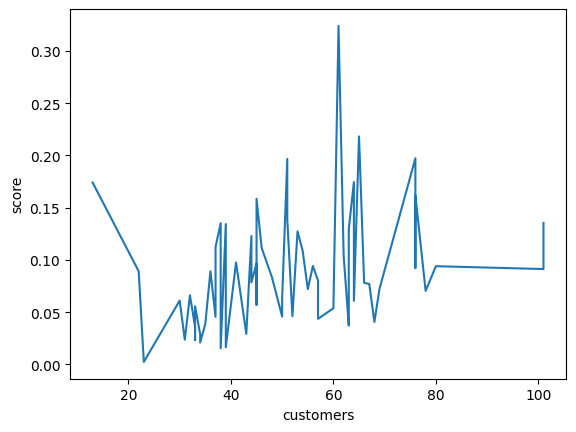

In [174]:
y = [results_[i]['score'] for i in range(len(results_))]
x = [int(results_[i]['filename'].split('-')[-2][1:]) for i in range(len(results_))]

plt.plot(np.delete(np.array(x)[np.argsort(x)], 5), np.delete(np.array(y)[np.argsort(x)], 5))
plt.ylabel('score')
plt.xlabel('customers')

In [168]:
np.array(y)[np.argsort(x)]

array([0.17408907, 0.08916897, 0.00239436, 0.0610851 , 0.0236001 ,
       2.27704485, 0.06617563, 0.03617612, 0.02335861, 0.05565793,
       0.02889938, 0.02096907, 0.03887116, 0.0890861 , 0.04549532,
       0.11248303, 0.13517344, 0.01548226, 0.1343546 , 0.07840476,
       0.0162757 , 0.09756553, 0.0292258 , 0.12283341, 0.07858807,
       0.09651761, 0.05705627, 0.0651118 , 0.15851141, 0.11145269,
       0.08351454, 0.04579299, 0.06387972, 0.19666446, 0.13851219,
       0.04622089, 0.12728739, 0.10879799, 0.0720287 , 0.09416381,
       0.08027073, 0.04358725, 0.0537869 , 0.32389722, 0.10405564,
       0.03714317, 0.04516507, 0.12957741, 0.17450613, 0.0609187 ,
       0.21818309, 0.07817919, 0.07690789, 0.04064344, 0.07243882,
       0.19720875, 0.0939313 , 0.09222931, 0.16177697, 0.07035813,
       0.09398556, 0.09126834, 0.13539136])

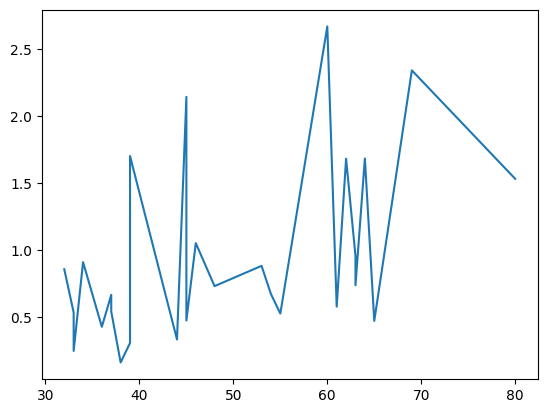

In [107]:
j = 0
plt.plot([int(results[j][i]['filename'].split('-')[-2][1:]) for i in range(len(results[j]))], [r['time'] for r in results[j]])

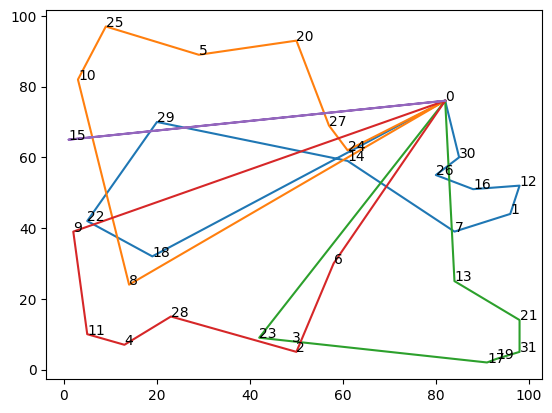

In [32]:
a = VRP.run_from_file('data/A/A-n32-k5.vrp', tabu_len=9, non_improvement_len=1000)

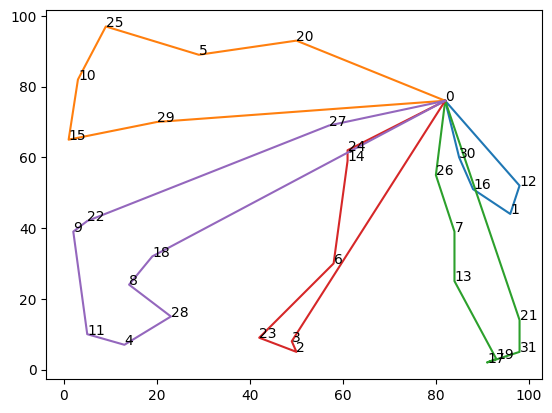

In [33]:
VRP.plot_routes(a['vehicles_optimized'], a['customers'])

In [34]:
a['score']

0.06617562628420846

In [52]:
for v in a['vehicles_optimized']:
    print(v.route)

[0, 18, 10, 19, 8, 0]
[0, 21, 30, 0]
[0, 2, 1, 20, 25, 0]
[0, 22, 6, 5, 16, 11, 13, 7, 15, 9, 14, 12, 0]
[0, 17, 27, 26, 0]
[0, 23, 29, 24, 0]
[0, 3, 28, 4, 0]


In [57]:
test = [Vehicle(140) for i in range(7)]
test[0].route = [0,30,0]
test[1].route = [0, 26, 4, 17, 5, 16, 0]
test[2].route = [0, 29, 23, 0]
test[3].route = [0, 21, 11, 13, 9, 28, 15, 0]
test[4].route = [0, 20, 6, 22, 8, 2, 19, 0]
test[5].route = [0, 25, 1, 14, 3, 24, 0] 
test[6].route = [0, 10, 18, 12, 7, 27, 0]

In [58]:
VRP.total_route_length(test, a['distance_matrix'])

1815.0

In [ ]:
instance = vrplib.read_instance(current_file)